# SAE embedding + DEC clustering + MLP classification: 
## from NME_DEC/decModel_wimgF_dualopt_descStats_NLL.py

In [3]:
import sys
import os
sys.path.insert(0,'Z:/Cristina/Section3/NME_DEC')
sys.path.insert(0,'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels')
# pylint: skip-file
import sys
import os
import mxnet as mx
import numpy as np
import pandas as pd
import data
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import model
from autoencoder import AutoEncoderModel
from solver import Solver, Monitor
import logging
import sklearn
from sklearn.manifold import TSNE
from utilities import *
try:
   import cPickle as pickle
except:
   import pickle
import gzip

# for visualization
from sklearn.manifold import TSNE
from utilities import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
NME_nxgraphs = r'Z:\Cristina\Section3\breast_MR_NME_biological\NMEs_SER_nxgmetrics'
    
allNMEs_dynamic = pd.read_csv(os.path.join(NME_nxgraphs,'dyn_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_morphology = pd.read_csv(os.path.join(NME_nxgraphs,'morpho_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_texture = pd.read_csv(os.path.join(NME_nxgraphs,'text_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_stage1 = pd.read_csv(os.path.join(NME_nxgraphs,'stage1_roi_records_allNMEs_descStats.csv'), index_col=0)

# to load SERw matrices for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGdatafeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    nxGdatafeatures = pickle.load(fin)

# to load discrall_dict dict for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGnormfeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    discrall_dict_allNMEs = pickle.load(fin)           

#########
# shape input (798L, 427L)     
nxGdiscfeatures = discrall_dict_allNMEs   
print('Loading {} leasions with nxGdiscfeatures of size = {}'.format(nxGdiscfeatures.shape[0], nxGdiscfeatures.shape[1]) )

print('Normalizing dynamic {} leasions with features of size = {}'.format(allNMEs_dynamic.shape[0], allNMEs_dynamic.shape[1]))
normdynamic = (allNMEs_dynamic - allNMEs_dynamic.mean(axis=0)) / allNMEs_dynamic.std(axis=0)
normdynamic.mean(axis=0)

print('Normalizing morphology {} leasions with features of size = {}'.format(allNMEs_morphology.shape[0], allNMEs_morphology.shape[1]))
normorpho = (allNMEs_morphology - allNMEs_morphology.mean(axis=0)) / allNMEs_morphology.std(axis=0)
normorpho.mean(axis=0)

print('Normalizing texture {} leasions with features of size = {}'.format(allNMEs_texture.shape[0], allNMEs_texture.shape[1]))
normtext = (allNMEs_texture - allNMEs_texture.mean(axis=0)) / allNMEs_texture.std(axis=0)
normtext.mean(axis=0)

print('Normalizing stage1 {} leasions with features of size = {}'.format(allNMEs_stage1.shape[0], allNMEs_stage1.shape[1]))
normstage1 = (allNMEs_stage1 - allNMEs_stage1.mean(axis=0)) / allNMEs_stage1.std(axis=0)
normstage1.mean(axis=0)

# shape input (798L, 427L)    
combX_allNME = np.concatenate((nxGdiscfeatures, normdynamic.as_matrix(), normorpho.as_matrix(), normtext.as_matrix(), normstage1.as_matrix()), axis=1)       
YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} all NME of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0])   )

# define variables for DEC 
roi_labels = YnxG_allNME[1]  
roi_labels = ['K' if rl=='U' else rl for rl in roi_labels]

## use y_dec to  minimizing KL divergence for clustering with known classes
ysup = ["{}_{}_{}".format(a, b, c) if b!='nan' else "{}_{}".format(a, c) for a, b, c in zip(YnxG_allNME[1], YnxG_allNME[2], YnxG_allNME[3])]
ysup = ['K'+rl[1::] if rl[0]=='U' else rl for rl in ysup]
classes = [str(c) for c in np.unique(ysup)]
numclasses = [i for i in range(len(classes))]
y_dec = []
for k in range(len(ysup)):
    for j in range(len(classes)):
        if(str(ysup[k])==classes[j]): 
            y_dec.append(numclasses[j])
y_dec = np.asarray(y_dec)
combX_allNME[np.isnan(combX_allNME)] = 0.00001


Loading 792 leasions with nxGdiscfeatures of size = 326
Normalizing dynamic 792 leasions with features of size = 34
Normalizing morphology 792 leasions with features of size = 19
Normalizing texture 792 leasions with features of size = 44
Normalizing stage1 792 leasions with features of size = 100
Loading 792 all NME of size = 523
Loading all NME lables [label,BIRADS,dist,enh] of size = 792


##################################################################
##  Unsupervised learning in optimal LD space: Fitting aN MLP DUAL OPTIMIZATION
################################################################## 

Loading autoencoder of znum = 261, mu = 3 , post training DEC results
DEC train init AUC = 0.655889780154
DEC train max meanAuc_cv = 0.678193701723 $\pm$ 0.0721564825939
DEC validation AUC at max meanAuc_cv = 0.714482758621

... MLP fully coneected layer trained on Z_train tested on Z_test


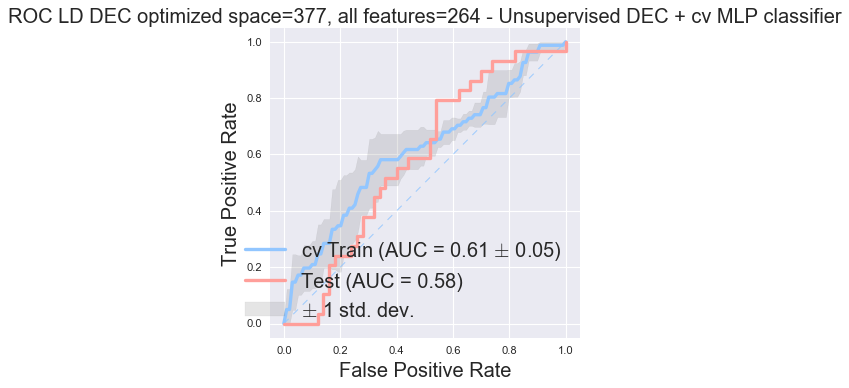

Loading autoencoder of znum = 261, mu = 4 , post training DEC results
DEC train init AUC = 0.645989304813
DEC train max meanAuc_cv = 0.696368092692 $\pm$ 0.103255317117
DEC validation AUC at max meanAuc_cv = 0.724827586207

... MLP fully coneected layer trained on Z_train tested on Z_test


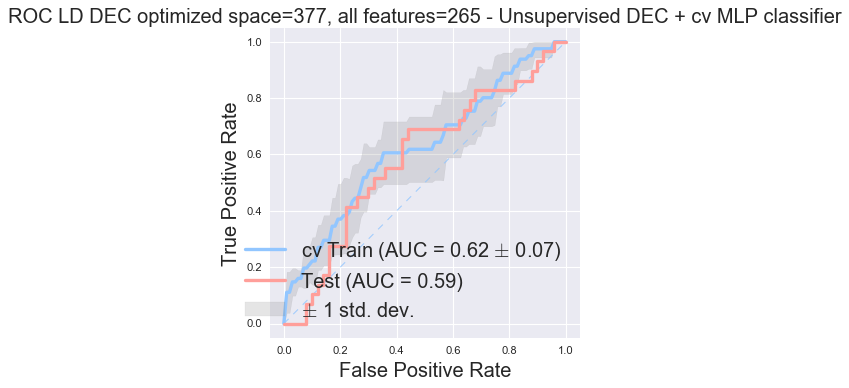

Loading autoencoder of znum = 261, mu = 5 , post training DEC results
DEC train init AUC = 0.667929292929
DEC train max meanAuc_cv = 0.66772875817 $\pm$ 0.0768471133707
DEC validation AUC at max meanAuc_cv = 0.682068965517

... MLP fully coneected layer trained on Z_train tested on Z_test


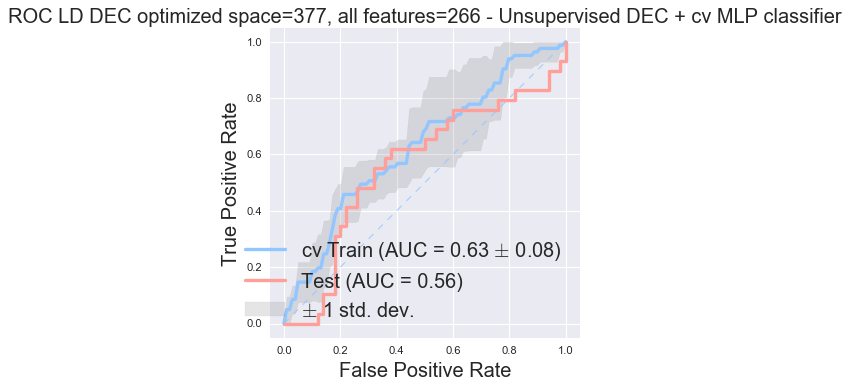

Loading autoencoder of znum = 261, mu = 6 , post training DEC results
DEC train init AUC = 0.699985145573
DEC train max meanAuc_cv = 0.686668152109 $\pm$ 0.108141742968
DEC validation AUC at max meanAuc_cv = 0.724137931034

... MLP fully coneected layer trained on Z_train tested on Z_test


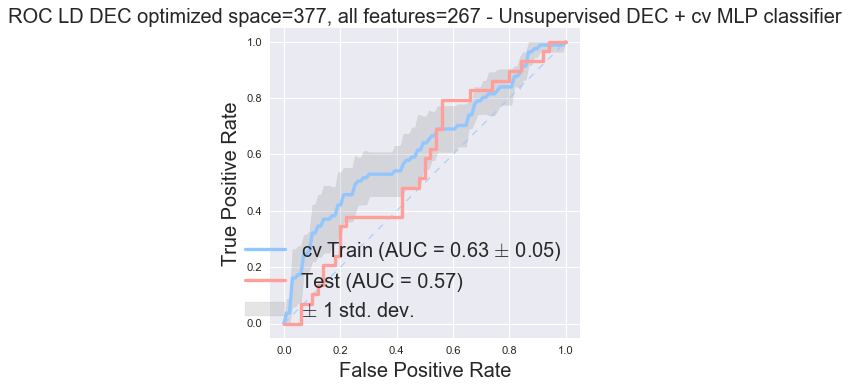

Loading autoencoder of znum = 261, mu = 7 , post training DEC results
DEC train init AUC = 0.653832442068
DEC train max meanAuc_cv = 0.642944147356 $\pm$ 0.085662538305
DEC validation AUC at max meanAuc_cv = 0.723448275862

... MLP fully coneected layer trained on Z_train tested on Z_test


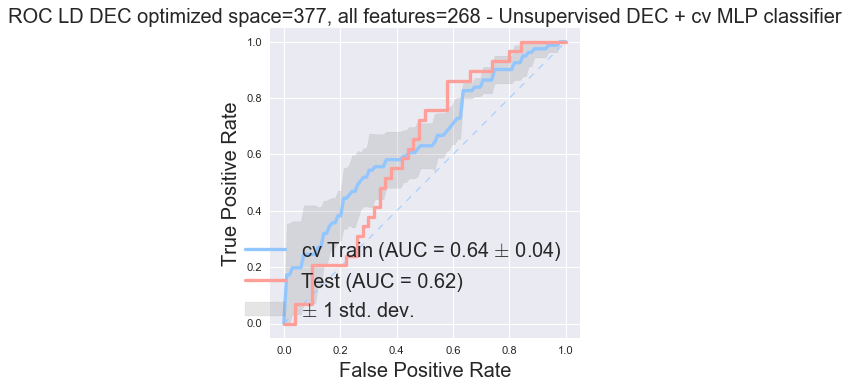

Loading autoencoder of znum = 261, mu = 8 , post training DEC results
DEC train init AUC = 0.665470885324
DEC train max meanAuc_cv = 0.700415923945 $\pm$ 0.0941334137603
DEC validation AUC at max meanAuc_cv = 0.692413793103

... MLP fully coneected layer trained on Z_train tested on Z_test


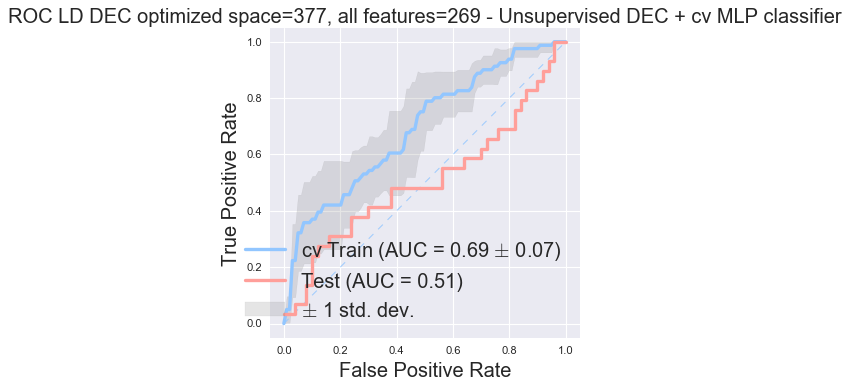

Loading autoencoder of znum = 261, mu = 9 , post training DEC results
DEC train init AUC = 0.669422162805
DEC train max meanAuc_cv = 0.661274509804 $\pm$ 0.0810870750805
DEC validation AUC at max meanAuc_cv = 0.680689655172

... MLP fully coneected layer trained on Z_train tested on Z_test


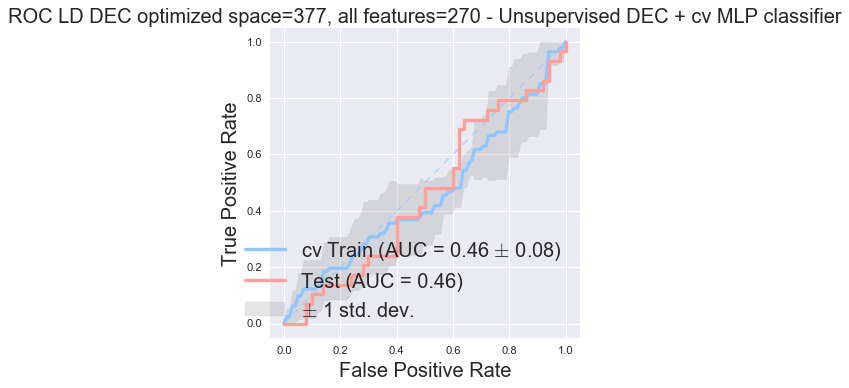

Loading autoencoder of znum = 261, mu = 10 , post training DEC results
DEC train init AUC = 0.663183303624
DEC train max meanAuc_cv = 0.677027629234 $\pm$ 0.0953513211229
DEC validation AUC at max meanAuc_cv = 0.645517241379

... MLP fully coneected layer trained on Z_train tested on Z_test


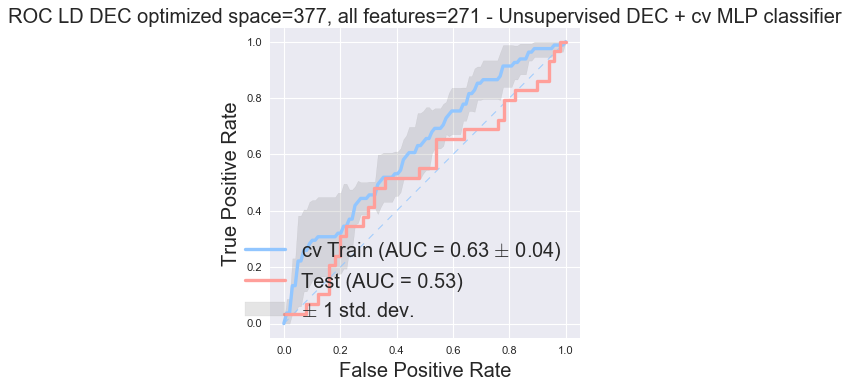

Loading autoencoder of znum = 261, mu = 11 , post training DEC results
DEC train init AUC = 0.692580213904
DEC train max meanAuc_cv = 0.697459893048 $\pm$ 0.0888467357632
DEC validation AUC at max meanAuc_cv = 0.697931034483

... MLP fully coneected layer trained on Z_train tested on Z_test


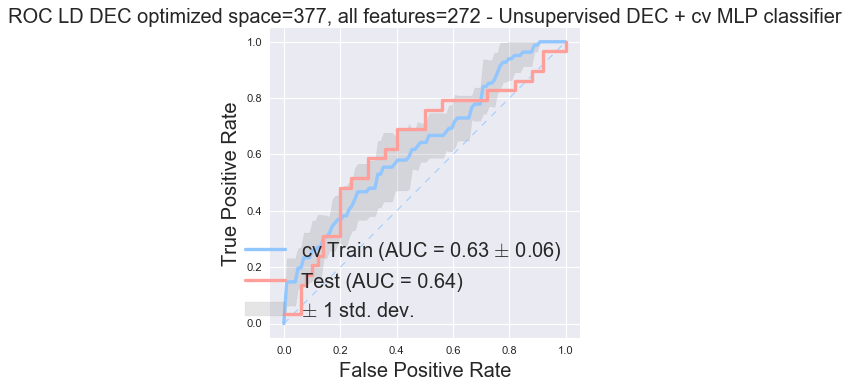

Loading autoencoder of znum = 261, mu = 12 , post training DEC results
DEC train init AUC = 0.681298276887
DEC train max meanAuc_cv = 0.687098930481 $\pm$ 0.0715511909833
DEC validation AUC at max meanAuc_cv = 0.74

... MLP fully coneected layer trained on Z_train tested on Z_test


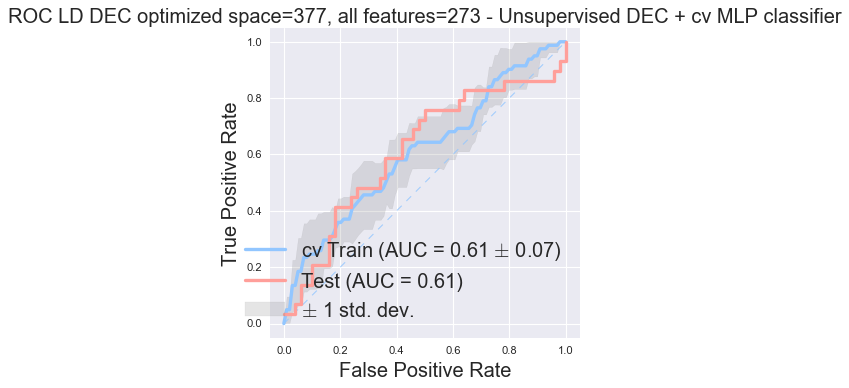

Loading autoencoder of znum = 104, mu = 3 , post training DEC results
DEC train init AUC = 0.631023469994
DEC train max meanAuc_cv = 0.65742721331 $\pm$ 0.0979429723712
DEC validation AUC at max meanAuc_cv = 0.685517241379

... MLP fully coneected layer trained on Z_train tested on Z_test


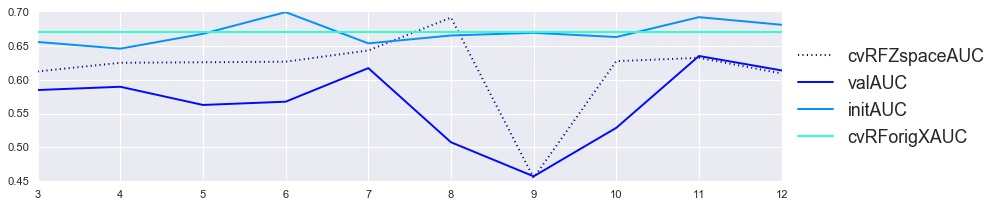

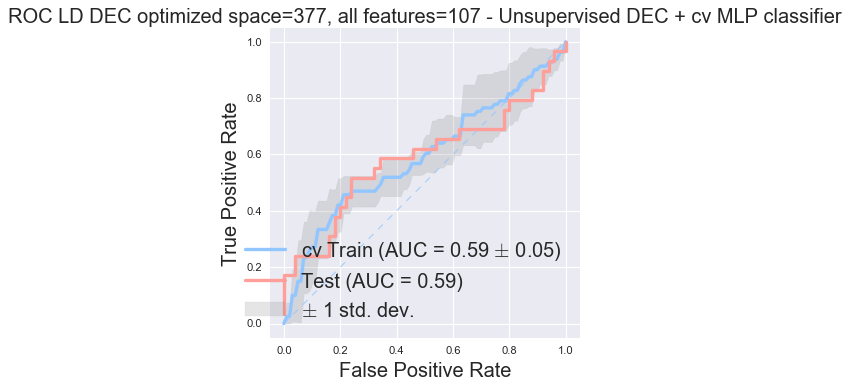

Loading autoencoder of znum = 104, mu = 4 , post training DEC results
DEC train init AUC = 0.630993761141
DEC train max meanAuc_cv = 0.643976530006 $\pm$ 0.100405169373
DEC validation AUC at max meanAuc_cv = 0.669655172414

... MLP fully coneected layer trained on Z_train tested on Z_test


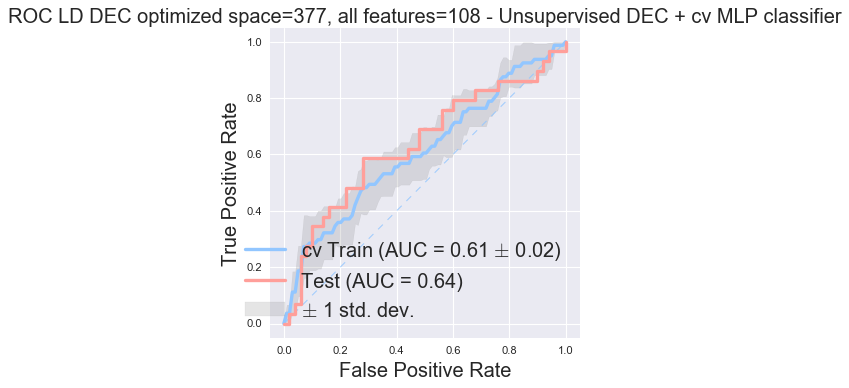

Loading autoencoder of znum = 104, mu = 5 , post training DEC results
DEC train init AUC = 0.664393939394
DEC train max meanAuc_cv = 0.646821152704 $\pm$ 0.101245204998
DEC validation AUC at max meanAuc_cv = 0.71724137931

... MLP fully coneected layer trained on Z_train tested on Z_test


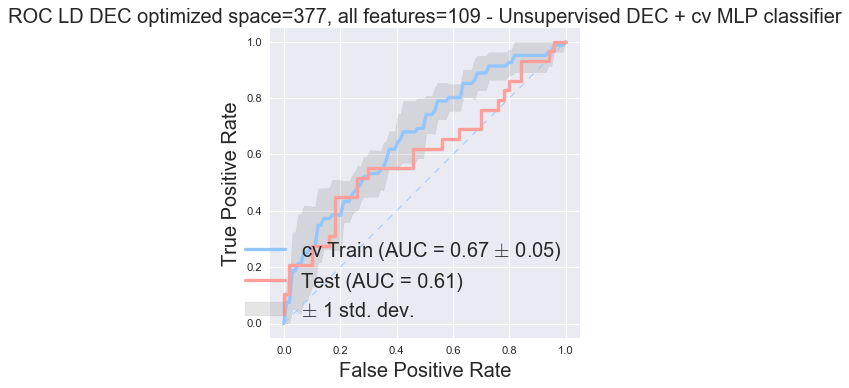

Loading autoencoder of znum = 104, mu = 6 , post training DEC results
DEC train init AUC = 0.61351010101
DEC train max meanAuc_cv = 0.644184491979 $\pm$ 0.109976306506
DEC validation AUC at max meanAuc_cv = 0.745517241379

... MLP fully coneected layer trained on Z_train tested on Z_test


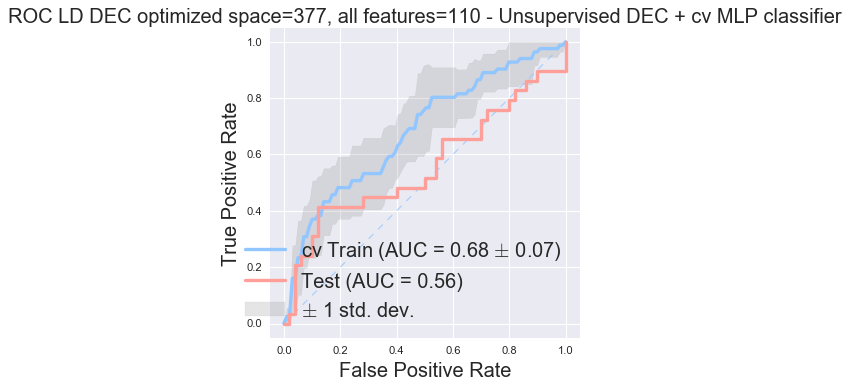

Loading autoencoder of znum = 104, mu = 7 , post training DEC results
DEC train init AUC = 0.66131164587
DEC train max meanAuc_cv = 0.656907308378 $\pm$ 0.113433213637
DEC validation AUC at max meanAuc_cv = 0.64275862069

... MLP fully coneected layer trained on Z_train tested on Z_test


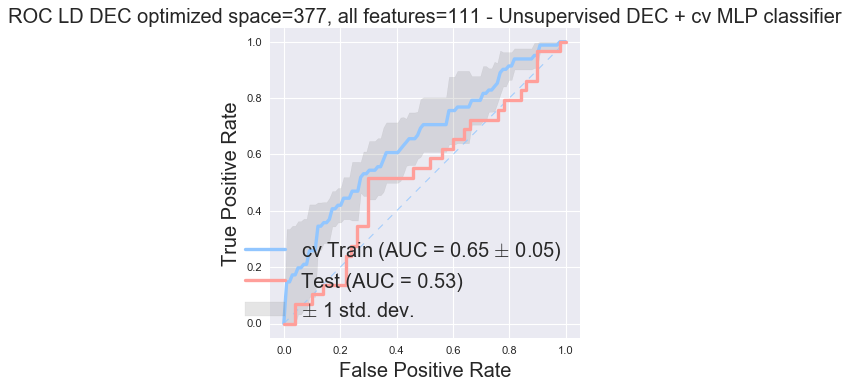

Loading autoencoder of znum = 104, mu = 8 , post training DEC results
DEC train init AUC = 0.639445929887
DEC train max meanAuc_cv = 0.63960932858 $\pm$ 0.0930201078281
DEC validation AUC at max meanAuc_cv = 0.696551724138

... MLP fully coneected layer trained on Z_train tested on Z_test


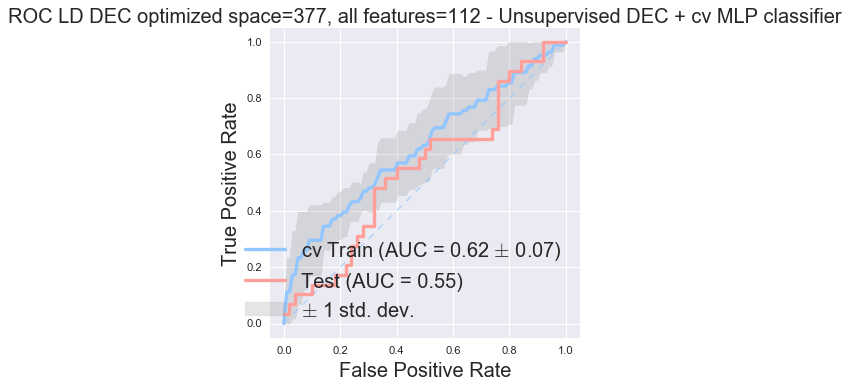

Loading autoencoder of znum = 104, mu = 9 , post training DEC results
DEC train init AUC = 0.68215983363
DEC train max meanAuc_cv = 0.654575163399 $\pm$ 0.122330116494
DEC validation AUC at max meanAuc_cv = 0.638620689655

... MLP fully coneected layer trained on Z_train tested on Z_test


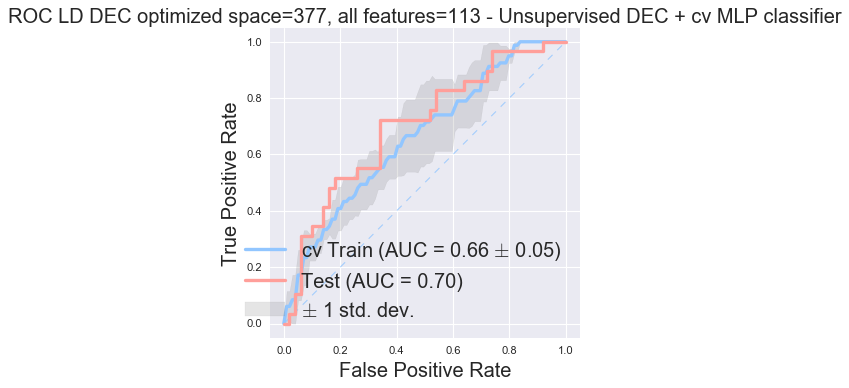

Loading autoencoder of znum = 104, mu = 10 , post training DEC results
DEC train init AUC = 0.616124480095
DEC train max meanAuc_cv = 0.636267082591 $\pm$ 0.124517728391
DEC validation AUC at max meanAuc_cv = 0.629655172414

... MLP fully coneected layer trained on Z_train tested on Z_test


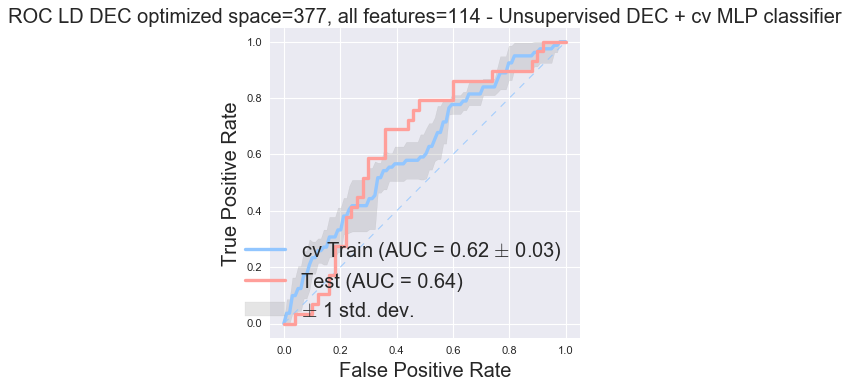

Loading autoencoder of znum = 104, mu = 11 , post training DEC results
DEC train init AUC = 0.643278371955
DEC train max meanAuc_cv = 0.659142899584 $\pm$ 0.133414164354
DEC validation AUC at max meanAuc_cv = 0.7

... MLP fully coneected layer trained on Z_train tested on Z_test


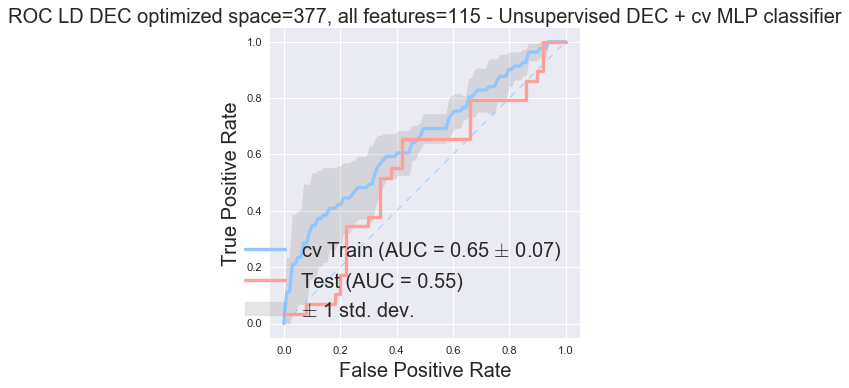

Loading autoencoder of znum = 104, mu = 12 , post training DEC results
DEC train init AUC = 0.637165775401
DEC train max meanAuc_cv = 0.658251633987 $\pm$ 0.0823802070919
DEC validation AUC at max meanAuc_cv = 0.706206896552

... MLP fully coneected layer trained on Z_train tested on Z_test


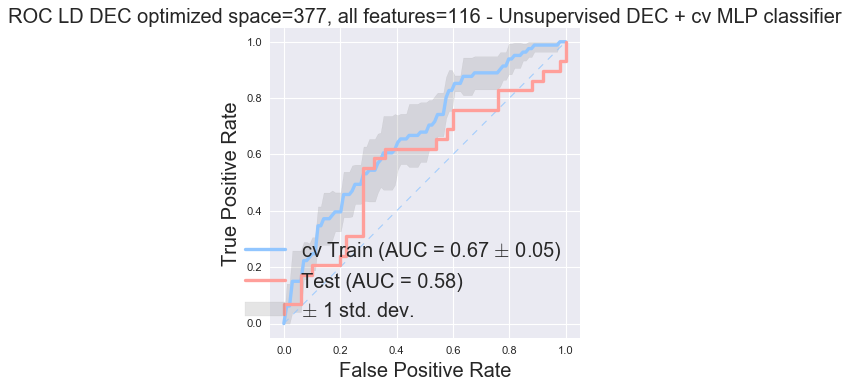

Loading autoencoder of znum = 52, mu = 3 , post training DEC results
DEC train init AUC = 0.601440879382
DEC train max meanAuc_cv = 0.646672608437 $\pm$ 0.0853285975054
DEC validation AUC at max meanAuc_cv = 0.688275862069

... MLP fully coneected layer trained on Z_train tested on Z_test


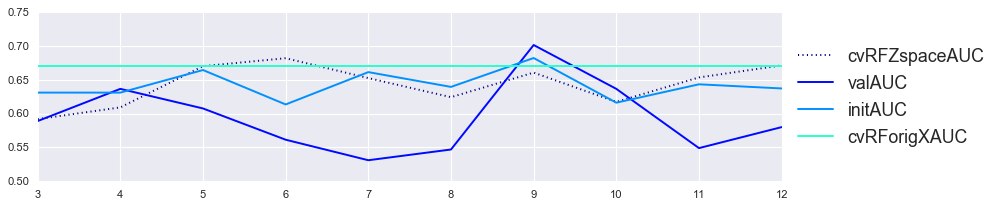

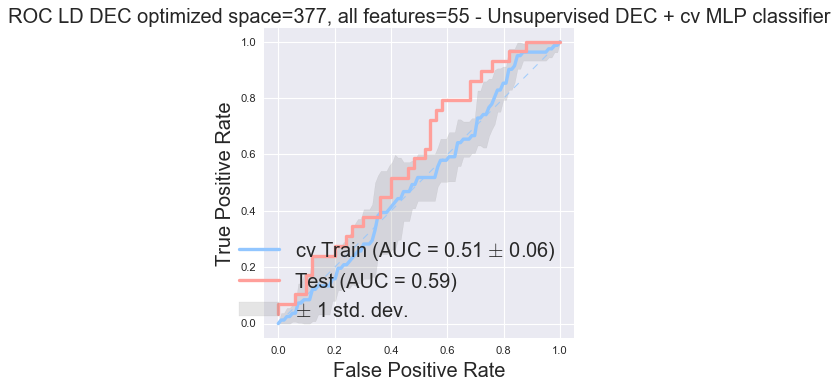

Loading autoencoder of znum = 52, mu = 4 , post training DEC results
DEC train init AUC = 0.631097742127
DEC train max meanAuc_cv = 0.613844325609 $\pm$ 0.09712611808
DEC validation AUC at max meanAuc_cv = 0.680689655172

... MLP fully coneected layer trained on Z_train tested on Z_test


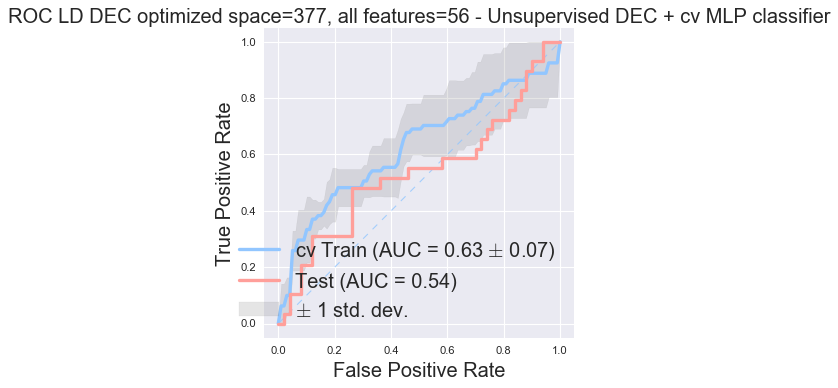

Loading autoencoder of znum = 52, mu = 5 , post training DEC results
DEC train init AUC = 0.635591206179
DEC train max meanAuc_cv = 0.616369578134 $\pm$ 0.0936005509773
DEC validation AUC at max meanAuc_cv = 0.686896551724

... MLP fully coneected layer trained on Z_train tested on Z_test


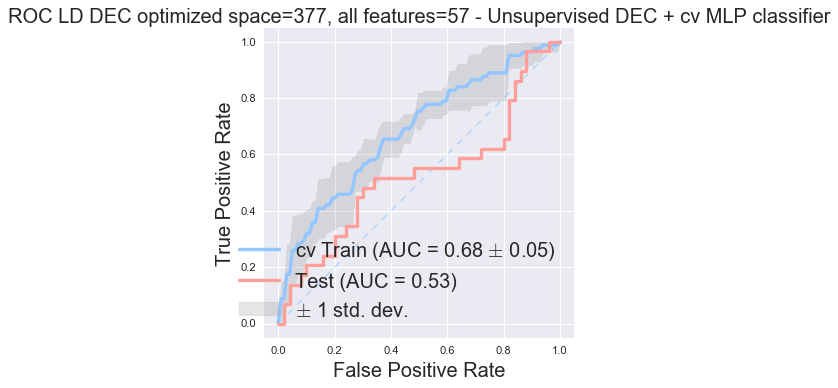

Loading autoencoder of znum = 52, mu = 6 , post training DEC results
DEC train init AUC = 0.639379084967
DEC train max meanAuc_cv = 0.585784313725 $\pm$ 0.0974454610612
DEC validation AUC at max meanAuc_cv = 0.60275862069

... MLP fully coneected layer trained on Z_train tested on Z_test


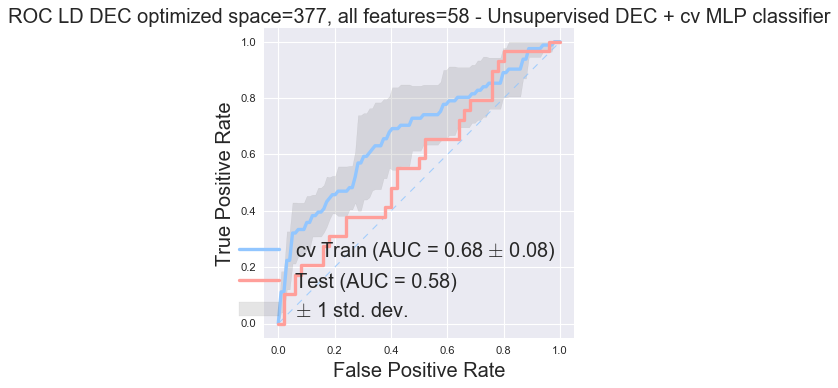

Loading autoencoder of znum = 52, mu = 7 , post training DEC results
DEC train init AUC = 0.617075163399
DEC train max meanAuc_cv = 0.599591503268 $\pm$ 0.0666556143181
DEC validation AUC at max meanAuc_cv = 0.690344827586

... MLP fully coneected layer trained on Z_train tested on Z_test


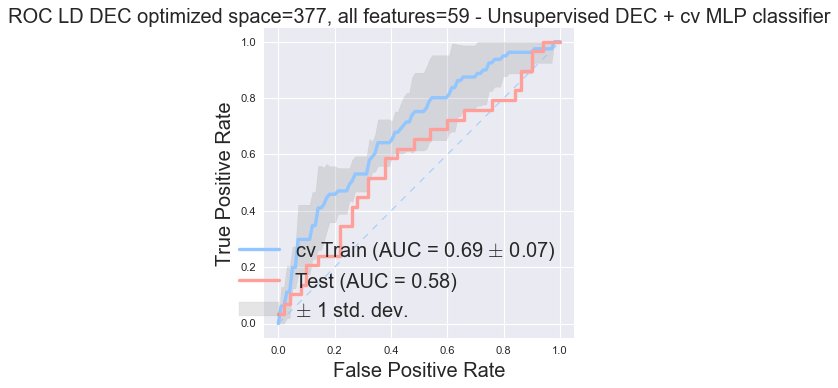

Loading autoencoder of znum = 52, mu = 8 , post training DEC results
DEC train init AUC = 0.602762923351
DEC train max meanAuc_cv = 0.630934343434 $\pm$ 0.0819593016337
DEC validation AUC at max meanAuc_cv = 0.700689655172

... MLP fully coneected layer trained on Z_train tested on Z_test


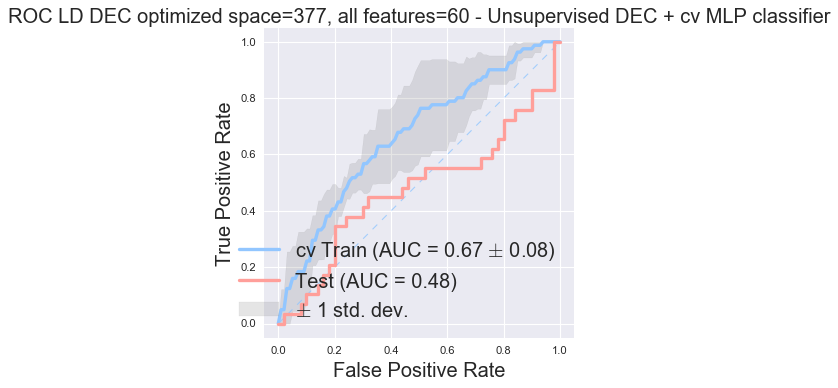

Loading autoencoder of znum = 52, mu = 9 , post training DEC results
DEC train init AUC = 0.619080510992
DEC train max meanAuc_cv = 0.639185977421 $\pm$ 0.0548919669978
DEC validation AUC at max meanAuc_cv = 0.659310344828

... MLP fully coneected layer trained on Z_train tested on Z_test


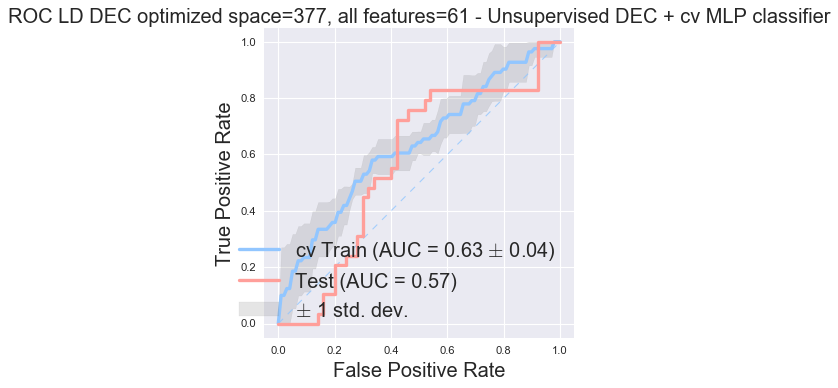

Loading autoencoder of znum = 52, mu = 10 , post training DEC results
DEC train init AUC = 0.627800059418
DEC train max meanAuc_cv = 0.625252525253 $\pm$ 0.0986022226877
DEC validation AUC at max meanAuc_cv = 0.652413793103

... MLP fully coneected layer trained on Z_train tested on Z_test


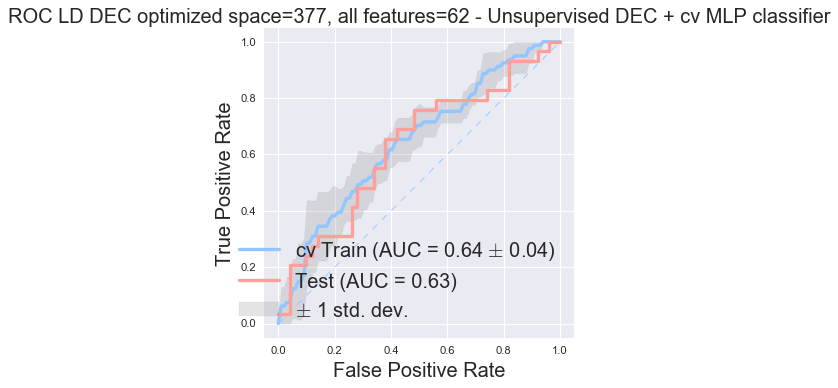

Loading autoencoder of znum = 52, mu = 11 , post training DEC results
DEC train init AUC = 0.625772430184
DEC train max meanAuc_cv = 0.649190433749 $\pm$ 0.079102974328
DEC validation AUC at max meanAuc_cv = 0.69724137931

... MLP fully coneected layer trained on Z_train tested on Z_test


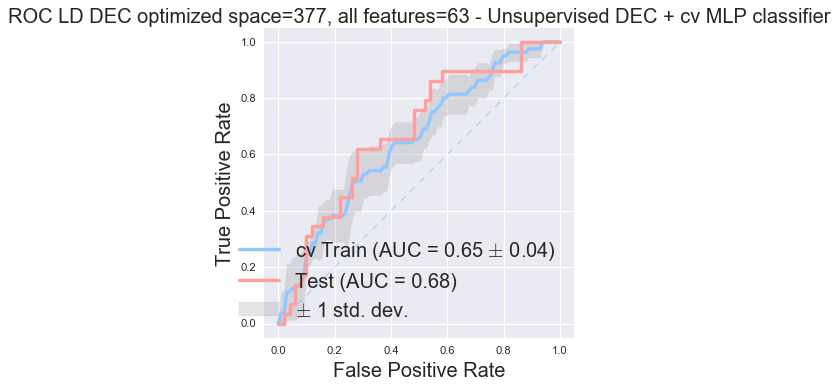

Loading autoencoder of znum = 52, mu = 12 , post training DEC results
DEC train init AUC = 0.619206773619
DEC train max meanAuc_cv = 0.610227272727 $\pm$ 0.0890997389664
DEC validation AUC at max meanAuc_cv = 0.69724137931

... MLP fully coneected layer trained on Z_train tested on Z_test


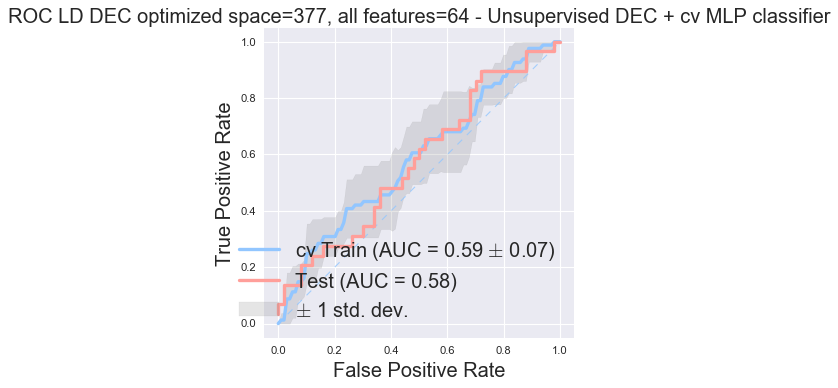

Loading autoencoder of znum = 34, mu = 3 , post training DEC results
DEC train init AUC = 0.656342840166
DEC train max meanAuc_cv = 0.645246583482 $\pm$ 0.0447582319865
DEC validation AUC at max meanAuc_cv = 0.719310344828

... MLP fully coneected layer trained on Z_train tested on Z_test


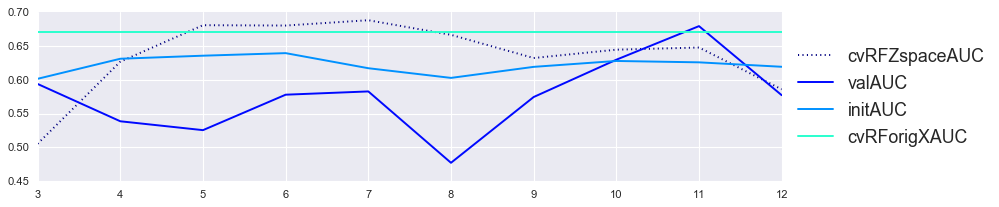

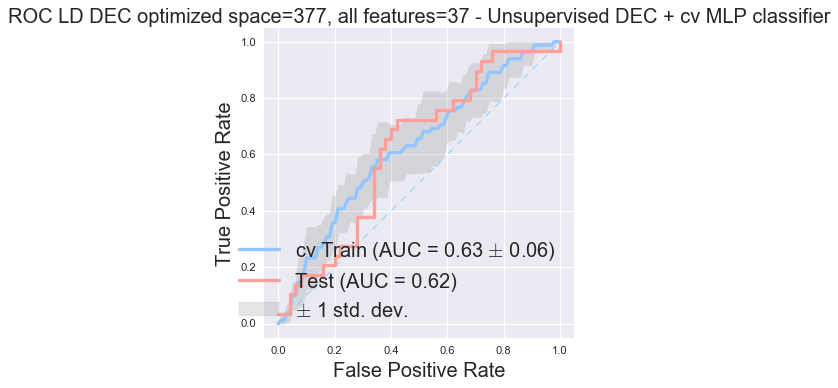

Loading autoencoder of znum = 34, mu = 4 , post training DEC results
DEC train init AUC = 0.633244206774
DEC train max meanAuc_cv = 0.622222222222 $\pm$ 0.0353373971871
DEC validation AUC at max meanAuc_cv = 0.735172413793

... MLP fully coneected layer trained on Z_train tested on Z_test


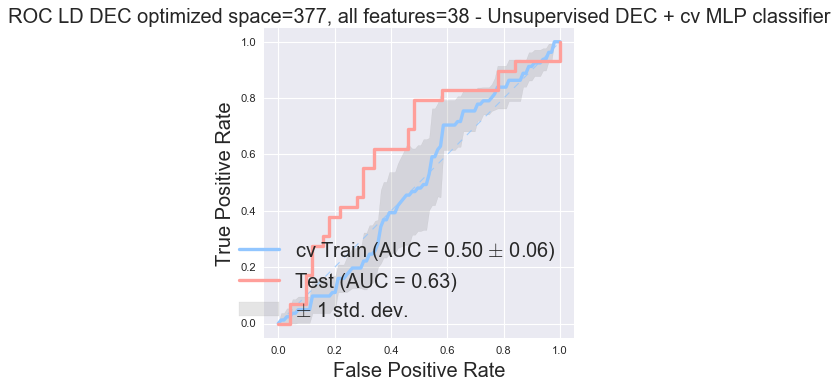

Loading autoencoder of znum = 34, mu = 5 , post training DEC results
DEC train init AUC = 0.60002228164
DEC train max meanAuc_cv = 0.623663101604 $\pm$ 0.0473771468972
DEC validation AUC at max meanAuc_cv = 0.689655172414

... MLP fully coneected layer trained on Z_train tested on Z_test


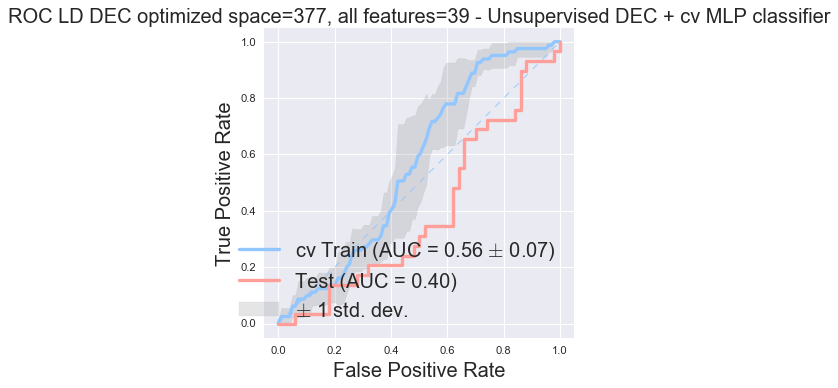

Loading autoencoder of znum = 34, mu = 6 , post training DEC results
DEC train init AUC = 0.61757278669
DEC train max meanAuc_cv = 0.658251633987 $\pm$ 0.106736977968
DEC validation AUC at max meanAuc_cv = 0.688965517241

... MLP fully coneected layer trained on Z_train tested on Z_test


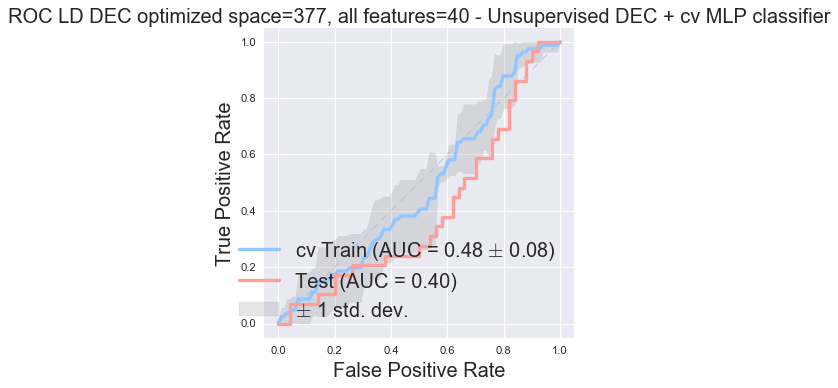

Loading autoencoder of znum = 34, mu = 7 , post training DEC results
DEC train init AUC = 0.646204693999
DEC train max meanAuc_cv = 0.619622697564 $\pm$ 0.0474618714595
DEC validation AUC at max meanAuc_cv = 0.731724137931

... MLP fully coneected layer trained on Z_train tested on Z_test


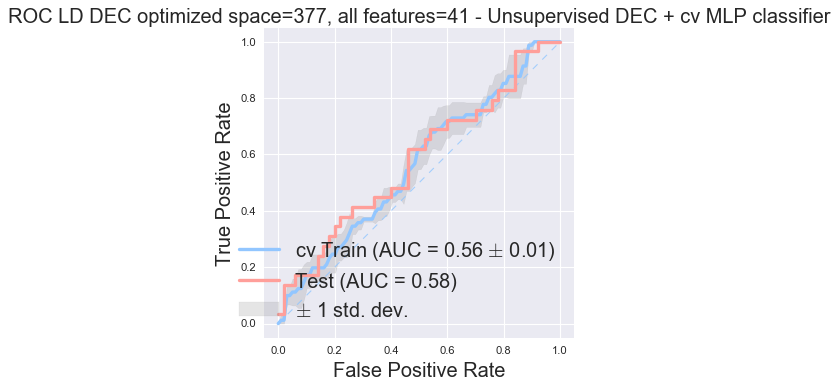

Loading autoencoder of znum = 34, mu = 8 , post training DEC results
DEC train init AUC = 0.600527332145
DEC train max meanAuc_cv = 0.614015151515 $\pm$ 0.0431608618007
DEC validation AUC at max meanAuc_cv = 0.689655172414

... MLP fully coneected layer trained on Z_train tested on Z_test


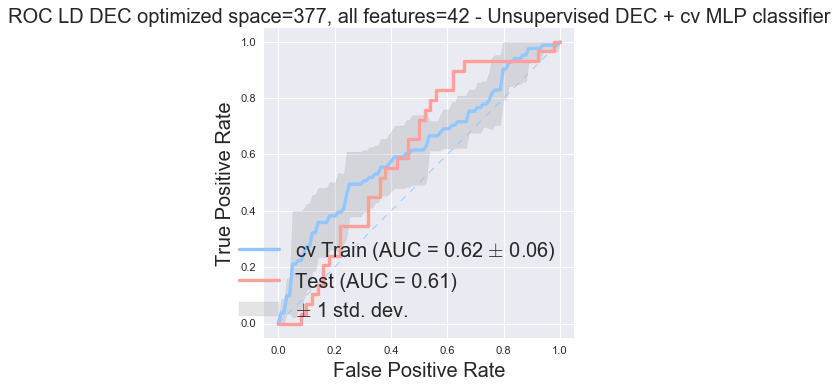

Loading autoencoder of znum = 34, mu = 9 , post training DEC results
DEC train init AUC = 0.619169637552
DEC train max meanAuc_cv = 0.62704248366 $\pm$ 0.0571391755834
DEC validation AUC at max meanAuc_cv = 0.724827586207

... MLP fully coneected layer trained on Z_train tested on Z_test


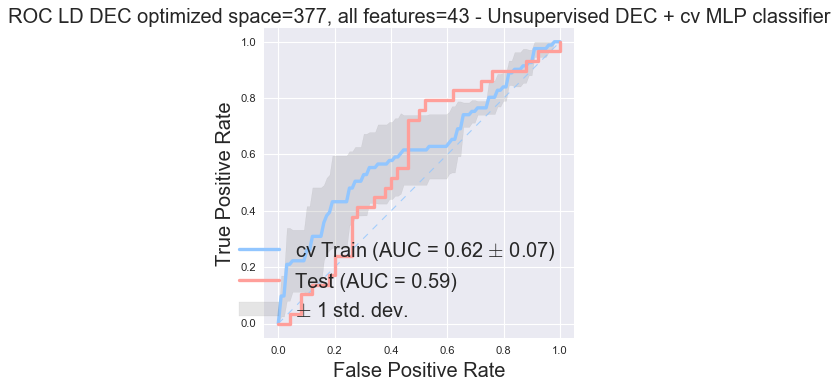

Loading autoencoder of znum = 34, mu = 10 , post training DEC results
DEC train init AUC = 0.61353238265
DEC train max meanAuc_cv = 0.615010398099 $\pm$ 0.0481744089902
DEC validation AUC at max meanAuc_cv = 0.656551724138

... MLP fully coneected layer trained on Z_train tested on Z_test


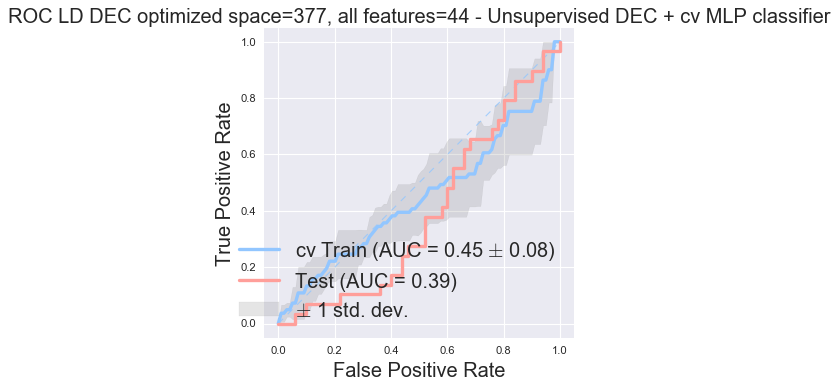

Loading autoencoder of znum = 34, mu = 11 , post training DEC results
DEC train init AUC = 0.611066547831
DEC train max meanAuc_cv = 0.648566547831 $\pm$ 0.0498108585952
DEC validation AUC at max meanAuc_cv = 0.793793103448

... MLP fully coneected layer trained on Z_train tested on Z_test


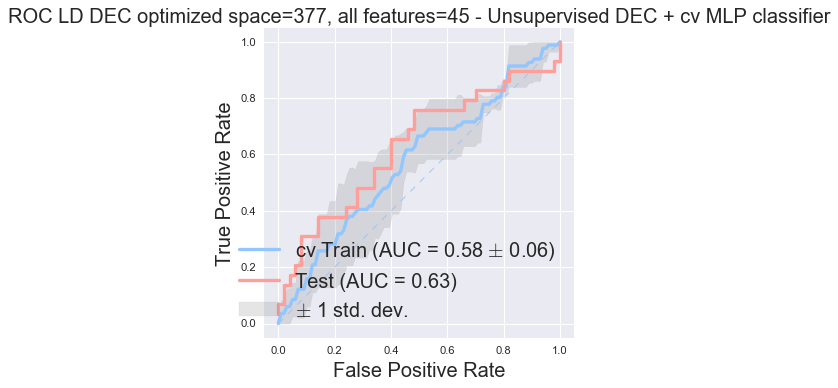

Loading autoencoder of znum = 34, mu = 12 , post training DEC results
DEC train init AUC = 0.601418597742
DEC train max meanAuc_cv = 0.622177658942 $\pm$ 0.0637052225814
DEC validation AUC at max meanAuc_cv = 0.711034482759

... MLP fully coneected layer trained on Z_train tested on Z_test


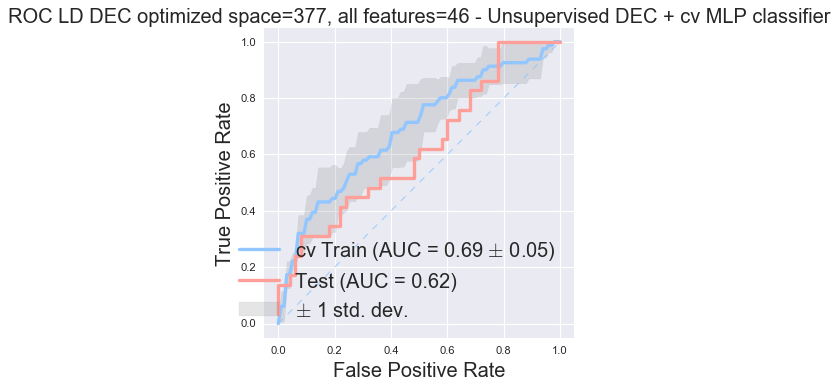

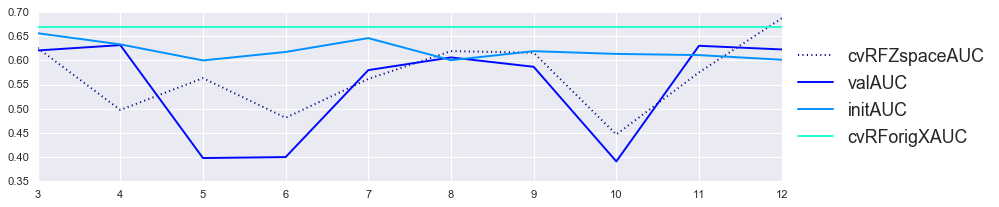

In [5]:
from decModel_wimgF_dualopt_descStats_NLLoss import *
labeltype = 'wimgF_dualopt_descStats_NLLoss' 
save_to = r'Z:\Cristina\Section3\NME_DEC\SAEmodels\decModel_wimgF_dualopt_descStats_NLLoss'
   
# to load a prevously DEC model  
input_size = combX_allNME.shape[1]
latent_size = [input_size/rxf for rxf in [2,5,10,15]] #[2]
varying_mu = [int(np.round(var_mu)) for var_mu in np.linspace(3,12,10)] #[3,7,8,10,12] # 

scoresM = np.zeros((len(latent_size),len(varying_mu),4))
scoresM_titles=[]

sns.set_color_codes("pastel")

######################
# DEC: define num_centers according to clustering variable
######################   
# to load a prevously DEC model  
for ik,znum in enumerate(latent_size):
    cvRForigXAUC = []
    initAUC = []
    valAUC = []
    cvRFZspaceAUC = [] 
    normalizedMI = []
    for ic,num_centers in enumerate(varying_mu): 
        X = combX_allNME
        y = roi_labels
        y_train_roi_labels = np.asarray(y)

        print('Loading autoencoder of znum = {}, mu = {} , post training DEC results'.format(znum,num_centers))
        dec_model = DECModel(mx.cpu(), X, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 

        with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            dec_model = pickle.load(fu)
          
        with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            outdict = pickle.load(fu)
        
        print('DEC train init AUC = {}'.format(outdict['meanAuc_cv'][0]))
        max_meanAuc_cv = outdict['meanAuc_cv'][-1]
        indmax_meanAuc_cv = outdict['meanAuc_cv'].index(max_meanAuc_cv)
        print r'DEC train max meanAuc_cv = {} $\pm$ {}'.format(max_meanAuc_cv,dec_model['std_auc'][indmax_meanAuc_cv])
        print('DEC validation AUC at max meanAuc_cv = {}'.format(outdict['auc_val'][indmax_meanAuc_cv]))
        
        #####################
        # extract Z-space from optimal DEC model
        #####################
        # saved output results
        dec_args_keys = ['encoder_1_bias', 'encoder_3_weight', 'encoder_0_weight', 
        'encoder_0_bias', 'encoder_2_weight', 'encoder_1_weight', 
        'encoder_3_bias', 'encoder_2_bias']
        dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
        dec_args['dec_mubestacci'] = dec_model['dec_mu']
        
        N = X.shape[0]
        all_iter = mx.io.NDArrayIter({'data': X}, batch_size=X.shape[0], shuffle=False,
                                                  last_batch_handle='pad')   
        ## extract embedded point zi 
        mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
        aDEC = DECModel(mx.cpu(), X, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 
        
        # organize weights and biases
        l1=[v.asnumpy().shape for k,v in aDEC.ae_model.args.iteritems()]
        k1=[k for k,v in aDEC.ae_model.args.iteritems()]
        l2=[v.asnumpy().shape for k,v in mxdec_args.iteritems()]
        k2=[k for k,v in mxdec_args.iteritems()]

        for ikparam,sizeparam in enumerate(l1):
            for jkparam,savedparam in enumerate(l2):
                if(sizeparam == savedparam):
                    #print('updating layer parameters: {}'.format(savedparam))
                    aDEC.ae_model.args[k1[ikparam]] = mxdec_args[k2[jkparam]]

        zbestacci = model.extract_feature(aDEC.feature, mxdec_args, None, all_iter, X.shape[0], aDEC.xpu).values()[0]      

        # compute model-based best-pbestacci or dec_model['pbestacci']
        pbestacci = np.zeros((zbestacci.shape[0], dec_model['num_centers']))
        aDEC.dec_op.forward([zbestacci, dec_args['dec_mubestacci'].asnumpy()], [pbestacci])
        #pbestacci = dec_model['pbestacci']
        
        # pool Z-space variables
        datalabels = np.asarray(y)
        dataZspace = np.concatenate((zbestacci, pbestacci), axis=1) 

        #####################
        # unbiased assessment: SPlit train/held-out test
        #####################
        # to compare performance need to discard unkown labels, only use known labels (only B or M)
        Z = dataZspace[datalabels!='K',:]
        y = datalabels[datalabels!='K']
      
        print '\n... MLP fully coneected layer trained on Z_train tested on Z_test' 
        sep = int(X.shape[0]*0.10)
        Z_test = Z[:sep]
        yZ_test = np.asanyarray(y[:sep]=='M').astype(int) 
        Z_train = Z[sep:]
        yZ_train = np.asanyarray(y[sep:]=='M').astype(int) 
       
        # We’ll load MLP using MXNet’s symbolic interface
        dataMLP = mx.sym.Variable('data')
        # MLP: two fully connected layers with 128 and 32 neurons each. 
        fc1  = mx.sym.FullyConnected(data=dataMLP, num_hidden = 128)
        act1 = mx.sym.Activation(data=fc1, act_type="relu")
        fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 32)
        act2 = mx.sym.Activation(data=fc2, act_type="relu")
        # data has 2 classes
        fc3  = mx.sym.FullyConnected(data=act2, num_hidden=2)
        # Softmax output layer
        mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
        # create a trainable module on CPU     
        batch_size = 50
        mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
        # pass train/test data to allocate model (bind state)
        MLP_train_iter = mx.io.NDArrayIter(Z_train, yZ_train, batch_size, shuffle=False)
        mlp_model.bind(MLP_train_iter.provide_data, MLP_train_iter.provide_label)
        mlp_model.init_params()   
        mlp_model.init_optimizer()
        mlp_model_params = mlp_model.get_params()[0]
        
        # update parameters based on optimal found during cv Training
        from mxnet import ndarray
        params_dict = ndarray.load(os.path.join(save_to,'mlp_model_params_z{}_mu{}.arg'.format(znum,num_centers)))
        arg_params = {}
        aux_params = {}
        for k, value in params_dict.items():
            arg_type, name = k.split(':', 1)
            if arg_type == 'arg':
                arg_params[name] = value
            elif arg_type == 'aux':
                aux_params[name] = value
            else:
                raise ValueError("Invalid param file ")

        # order of params: [(128L, 266L),(128L,),(32L, 128L),(32L,),(2L, 32L),(2L,)]
        # organize weights and biases
        l1=[v.asnumpy().shape for k,v in mlp_model_params.iteritems()]
        k1=[k for k,v in mlp_model_params.iteritems()]
        l2=[v.asnumpy().shape for k,v in arg_params.iteritems()]
        k2=[k for k,v in arg_params.iteritems()]

        for ikparam,sizeparam in enumerate(l1):
            for jkparam,savedparam in enumerate(l2):
                if(sizeparam == savedparam):
                    #print('updating layer parameters: {}'.format(savedparam))
                    mlp_model_params[k1[ikparam]] = arg_params[k2[jkparam]]
        # upddate model parameters
        mlp_model.set_params(mlp_model_params, aux_params)
        
        #####################
        # ROC: Z-space MLP fully coneected layer for classification
        #####################
        figROCs = plt.figure(figsize=(5,5))    
        axaroc = figROCs.add_subplot(1,1,1)
        # Run classifier with cross-validation and plot ROC curves
        cv = StratifiedKFold(n_splits=5,random_state=3)
        # Evaluate a score by cross-validation
        tprs = []; aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        cvi = 0
        for train, test in cv.split(Z_train, yZ_train):
            # Pass cv data
            MLP_val_iter = mx.io.NDArrayIter(Z_train[test], yZ_train[test], batch_size)    
            # prob[i][j] is the probability that the i-th validation contains the j-th output class.
            prob_val = mlp_model.predict(MLP_val_iter)
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(yZ_train[test], prob_val.asnumpy()[:,1])
            # to create an ROC with 100 pts
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            # plot
            #axaroc.plot(fpr, tpr, lw=1, alpha=0.6) # with label add: label='cv %d, AUC %0.2f' % (cvi, roc_auc)
            cvi += 1
            
        axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b', alpha=.8)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        axaroc.plot(mean_fpr, mean_tpr, color='b',
                    label=r'cv Train (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=3, alpha=1)     
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.') 
        
        ################
        # plot AUC on validation set
        ################
        MLP_heldout_iter = mx.io.NDArrayIter(Z_test, None, batch_size)   
        probas_heldout = mlp_model.predict(MLP_heldout_iter)
           
        # Compute ROC curve and area the curve
        fpr_val, tpr_val, thresholds_val = roc_curve(yZ_test, probas_heldout.asnumpy()[:, 1])
        auc_val = auc(fpr_val, tpr_val)
        axaroc.plot(fpr_val, tpr_val, color='r',
                    label=r'Test (AUC = %0.2f)' % (auc_val),lw=3, alpha=1)     

        axaroc.set_xlim([-0.05, 1.05])
        axaroc.set_ylim([-0.05, 1.05])
        axaroc.set_xlabel('False Positive Rate',fontsize=18)
        axaroc.set_ylabel('True Positive Rate',fontsize=18)
        axaroc.set_title('ROC LD DEC optimized space={}, all features={} - Unsupervised DEC + cv MLP classifier'.format(Z.shape[0],Z.shape[1]),fontsize=18)
        axaroc.legend(loc="lower right",fontsize=18)
        plt.show()
    
        ############# append to 
        cvRForigXAUC.append(0.67)
        initAUC.append(dec_model['meanAuc_cv'][0])
        cvRFZspaceAUC.append(np.mean(aucs))
        valAUC.append(auc_val)
        
        scoresM[ik,ic,0] = np.mean(aucs)
        scoresM_titles.append("DEC best mean_cvAUC")
        scoresM[ik,ic,1] = std_auc
        scoresM_titles.append("DEC best std_cvAUC")        
        scoresM[ik,ic,2] = auc_val
        scoresM_titles.append("DEC heal-out test AUC")        
 
        
    # plot latent space Accuracies vs. original
    colors = plt.cm.jet(np.linspace(0, 1, 16))
    fig2 = plt.figure(figsize=(12,6))
    #ax2 = plt.axes()
    sns.set_context("notebook")
    ax1 = fig2.add_subplot(2,1,1)
    ax1.plot(varying_mu, cvRFZspaceAUC, color=colors[0], ls=':', label='cvRFZspaceAUC')
    ax1.plot(varying_mu, valAUC, color=colors[2], label='valAUC')
    ax1.plot(varying_mu, initAUC, color=colors[4], label='initAUC')
    ax1.plot(varying_mu, cvRForigXAUC, color=colors[6], label='cvRForigXAUC')
    h1, l1 = ax1.get_legend_handles_labels()
    ax1.legend(h1, l1, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':16})
     

##################################################################
## Find best performing parameters
################################################################## 

original input space = 523


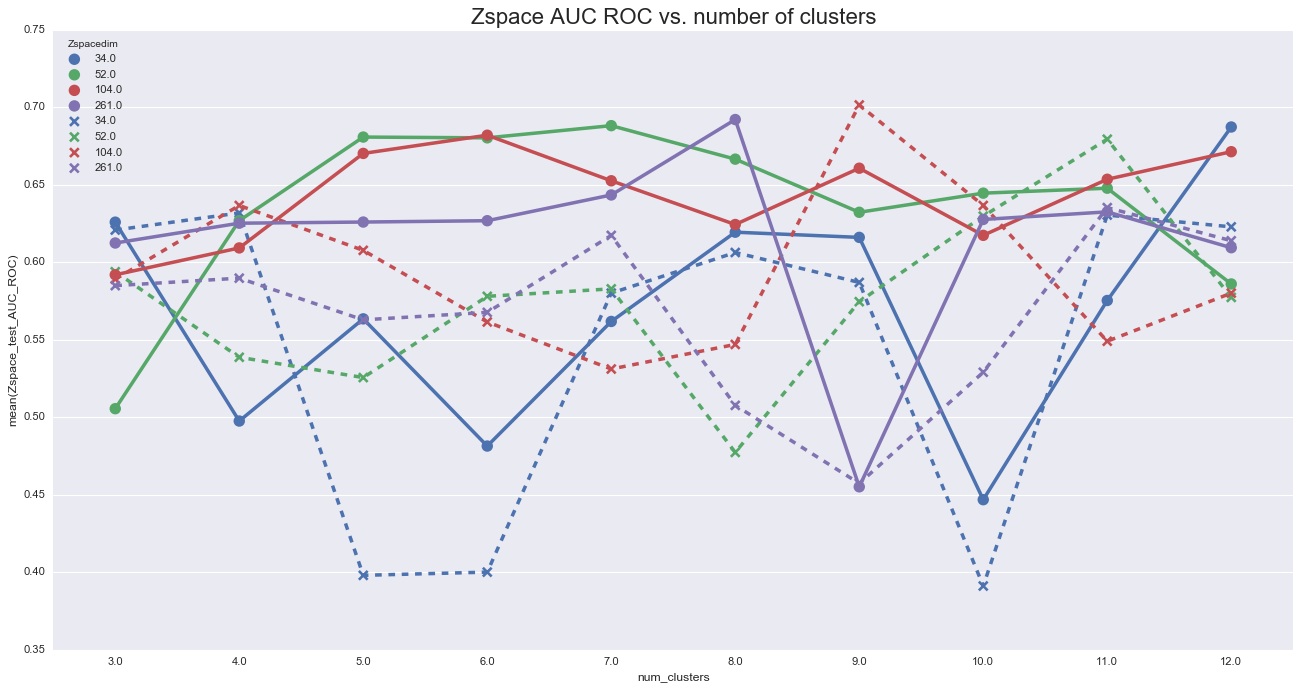

In [6]:
input_size = combX_allNME.shape[1]
print "original input space = %d" % input_size 
dict_aucZlatent = pd.DataFrame() 
for k,znum in enumerate(latent_size):
    for l,num_c in enumerate(varying_mu):
        dict_aucZlatent = dict_aucZlatent.append( pd.Series({'Zspacedim':znum, 
                                                             'Zspace_AUC_ROC': scoresM[k,l,0], 
                                                              'Zspace_test_AUC_ROC': scoresM[k,l,2], 
                                                             'num_clusters':num_c}), ignore_index=True)
fig2 = plt.figure(figsize=(20,10))
ax2 = plt.axes()
sns.set_context("notebook")  
sns.pointplot(x="num_clusters", y="Zspace_AUC_ROC", hue="Zspacedim", data=dict_aucZlatent, ax=ax2, size=0.05) 
sns.pointplot(x="num_clusters", y="Zspace_test_AUC_ROC", hue="Zspacedim", data=dict_aucZlatent, ax=ax2, size=0.05, markers=["x","x","x","x"],linestyles=["--","--","--","--"]) 
ax2.xaxis.set_label('# clusters')
ax2.yaxis.set_label('Zspace AUC ROC')
ax2.set_title('Zspace AUC ROC vs. number of clusters',fontsize=20)



In [7]:
# plot box plots
dict_aucZlatent['Zspacedim_cats'] = pd.Series(dict_aucZlatent['Zspacedim'], dtype="category")
dict_aucZlatent['num_clusters_cats'] = pd.Series(dict_aucZlatent['num_clusters'], dtype="category")
print dict_aucZlatent

    Zspace_AUC_ROC  Zspace_test_AUC_ROC  Zspacedim  num_clusters  \
0         0.612329             0.584828        261             3   
1         0.625116             0.589655        261             4   
2         0.625856             0.562759        261             5   
3         0.626719             0.567586        261             6   
4         0.643325             0.617241        261             7   
5         0.691983             0.507586        261             8   
6         0.455044             0.457241        261             9   
7         0.627535             0.528966        261            10   
8         0.632419             0.635172        261            11   
9         0.609289             0.613793        261            12   
10        0.591815             0.588966        104             3   
11        0.609153             0.636552        104             4   
12        0.670132             0.607586        104             5   
13        0.681885             0.561379        1

In [8]:
# find best performing by the average of broth train and test performance
max_aucZlatent = np.max(dict_aucZlatent[["Zspace_AUC_ROC", "Zspace_test_AUC_ROC"]].mean(axis=1))
indmax_meanAuc_cv = dict_aucZlatent[["Zspace_AUC_ROC", "Zspace_test_AUC_ROC"]].mean(axis=1) == max_aucZlatent
print "\n================== Best average train/test perfomance parameters:" 
bestperf_params = dict_aucZlatent[indmax_meanAuc_cv]
print bestperf_params

################################################################## 
Zspacedim_best = int(bestperf_params.iloc[0]['Zspacedim'])
num_clusters_best = int(bestperf_params.iloc[0]['num_clusters'])


================== Best average train/test perfomance parameters:
    Zspace_AUC_ROC  Zspace_test_AUC_ROC  Zspacedim  num_clusters  \
16        0.660593             0.701379        104             9   

   Zspacedim_cats num_clusters_cats  
16            104                 9  


## t-SNE: Visualizing Clusters

In [10]:
def plot_embedding_unsuper_local(Z_tsne, y_tsne, ax, title=None, legend=True, withClustersImg=True):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib import offsetbox
    from matplotlib.offsetbox import TextArea, AnnotationBbox
    
    x_min, x_max = np.min(Z_tsne, 0), np.max(Z_tsne, 0)
    Z_tsne = (Z_tsne - x_min) / (x_max - x_min)

    # process labels 
    classes = [str(c) for c in np.unique(y_tsne)]
    #classes.remove('K_N/A')
    colors=plt.cm.winter(np.linspace(0,1,len(classes))) # plt.cm.gist_rainbow
    c_patchs = []
    greyc_U = np.array([0.5,0.5,0.5,0.5])
    for k in range(len(classes)):
        if(str(classes[k])!='K'):
            c_patchs.append(mpatches.Patch(color=colors[k], label=classes[k]))
        else:
            c_patchs.append(mpatches.Patch(color=greyc_U, label='unknown'))

    for i in range(Z_tsne.shape[0]):
        for k in range(len(classes)):
            if str(y_tsne[i])==classes[k]: 
                colori = colors[k]     
                
        if(str(y_tsne[i])!='K'):
            plt.text(Z_tsne[i, 0], Z_tsne[i, 1], str(y_tsne[i]), color=colori,
                     fontdict={'weight': 'bold', 'size': 10})
        else:        
            #print('{}..{}'.format(i,str(named_y[i])))
            plt.text(Z_tsne[i, 0], Z_tsne[i, 1], '.', color=greyc_U,
                 fontdict={'weight': 'bold', 'size': 32}) 
                     
            
    if(legend):
        plt.legend(handles=c_patchs, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':14})
      
    ax.set_xticks([])
    ax.set_yticks([])
    
    if title is not None:
        plt.title(title)

Loading autoencoder of Zspacedim_best = 261, mu = 3 , post training DEC results
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 792 / 792
[t-SNE] Mean sigma: 0.206111
[t-SNE] Iteration 25: error = 17.1479496, gradient norm = 0.1988454
[t-SNE] Iteration 50: error = 17.8618917, gradient norm = 0.1780673
[t-SNE] Iteration 75: error = 17.9096783, gradient norm = 0.1799769
[t-SNE] Iteration 100: error = 17.2212957, gradient norm = 0.1847580
[t-SNE] KL divergence after 100 iterations with early exaggeration: 17.221296
[t-SNE] Iteration 125: error = 1.6972918, gradient norm = 0.0057362
[t-SNE] Iteration 150: error = 1.6725805, gradient norm = 0.0016665
[t-SNE] Iteration 175: error = 1.6680638, gradient norm = 0.0015625
[t-SNE] Iteration 200: error = 1.6668516, gradient norm = 0.0015538
[t-SNE] Iteration 225: error = 1.6665170, gradient norm = 0.0015501
[t-SNE] Iteration 250: error = 1.6664246, gradient norm = 0.0015490
[t-SNE] Iteration 275: error

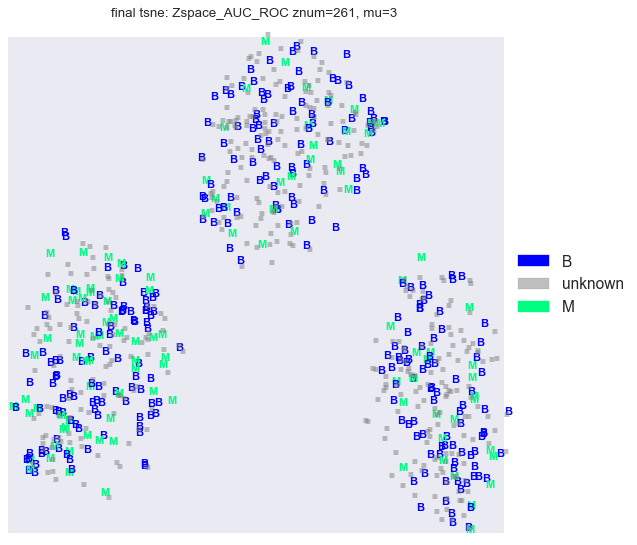

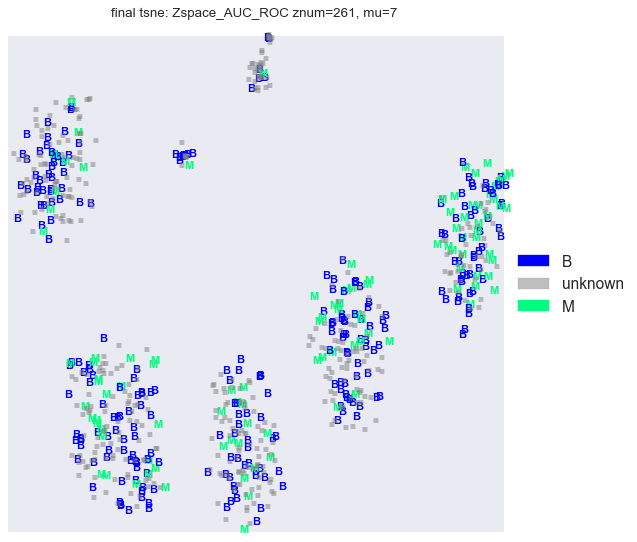

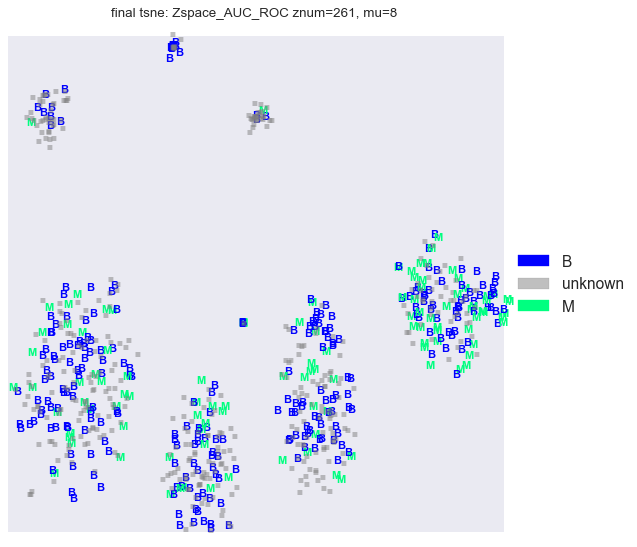

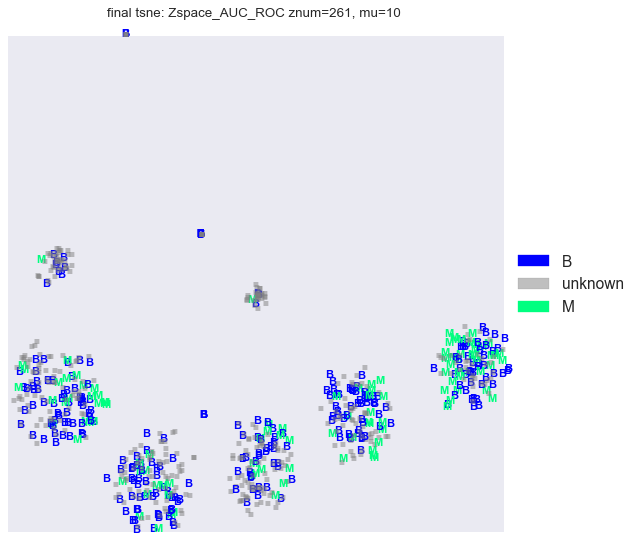

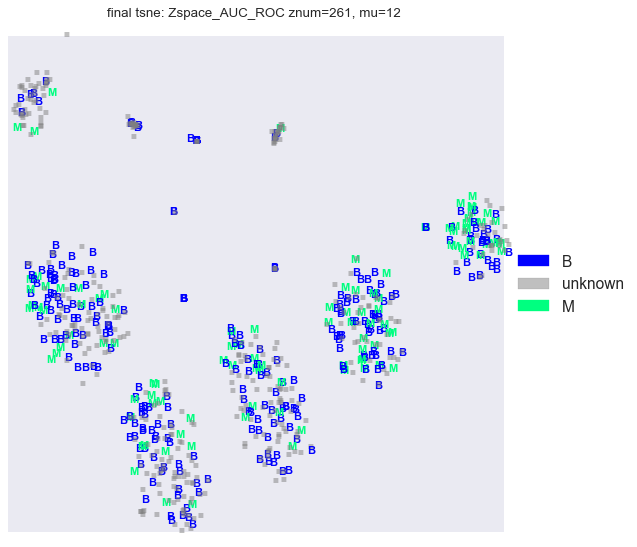

In [11]:
# to load a prevously DEC model  
input_size = combX_allNME.shape[1]
latent_size = [input_size/rxf for rxf in [2]]
varying_mu = [3,7,8,10,12] #[int(np.round(var_mu)) for var_mu in np.linspace(3,12,10]

######################
# DEC: define num_centers according to clustering variable
######################   
# to load a prevously DEC model  
for Zspacedim_best in latent_size:
    for num_clusters_best in varying_mu:

        print('Loading autoencoder of Zspacedim_best = {}, mu = {} , post training DEC results'.format(Zspacedim_best,num_clusters_best))
        
        with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(Zspacedim_best,num_clusters_best,labeltype)), 'rb') as fu:
            dec_model = pickle.load(fu)
          
        with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(Zspacedim_best,num_clusters_best,labeltype)), 'rb') as fu:
            outdict = pickle.load(fu)
            
        #####################
        # extract Z-space from optimal DEC model
        #####################
        # saved output results
        X = combX_allNME
        y = roi_labels
        
        dec_args_keys = ['encoder_1_bias', 'encoder_3_weight', 'encoder_0_weight', 
        'encoder_0_bias', 'encoder_2_weight', 'encoder_1_weight', 
        'encoder_3_bias', 'encoder_2_bias']
        dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
        dec_args['dec_mubestacci'] = dec_model['dec_mu']
        
        N = X.shape[0]
        all_iter = mx.io.NDArrayIter({'data': X}, 
                                     batch_size=X.shape[0],
                                     shuffle=False,
                                     last_batch_handle='pad')   
        ## extract embedded point zi 
        mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
        aDEC = DECModel(mx.cpu(), X, num_clusters_best, 1.0, Zspacedim_best, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 
        
        # organize weights and biases
        l1=[v.asnumpy().shape for k,v in aDEC.ae_model.args.iteritems()]
        k1=[k for k,v in aDEC.ae_model.args.iteritems()]
        l2=[v.asnumpy().shape for k,v in mxdec_args.iteritems()]
        k2=[k for k,v in mxdec_args.iteritems()]
        
        for ikparam,sizeparam in enumerate(l1):
            for jkparam,savedparam in enumerate(l2):
                if(sizeparam == savedparam):
                    #print('updating layer parameters: {}'.format(savedparam))
                    aDEC.ae_model.args[k1[ikparam]] = mxdec_args[k2[jkparam]]
        
        zbestacci = model.extract_feature(aDEC.feature, mxdec_args, None, all_iter, X.shape[0], aDEC.xpu).values()[0]      
        
        # compute model-based best-pbestacci or dec_model['pbestacci']
        pbestacci = np.zeros((zbestacci.shape[0], dec_model['num_centers']))
        aDEC.dec_op.forward([zbestacci, dec_args['dec_mubestacci'].asnumpy()], [pbestacci])
        #pbestacci = dec_model['pbestacci']
        
        # pool Z-space variables
        dataZspace = np.concatenate((zbestacci, pbestacci), axis=1) 
        
        figtsne = plt.figure(figsize=(8,8))
        axtsne = figtsne.add_subplot(1,1,1)
                    
        tsne = TSNE(n_components=2, perplexity=15, learning_rate=125,
             init='pca', random_state=0, verbose=2, method='exact')
        
        Z_tsne = tsne.fit_transform(zbestacci)   
        y_tsne = y #dec_model['named_y']
        
        # plot
        #plot_embedding_unsuper_NMEdist_intenh(Z_tsne, named_y, axtsne, title='final tsne: Zspace_AUC_ROC znum={}, mu={} \n'.format(Zspacedim_best,num_clusters_best), legend=True)
        plot_embedding_unsuper_local(Z_tsne, y_tsne, axtsne, 
                                     title='final tsne: Zspace_AUC_ROC znum={}, mu={} \n'.format(Zspacedim_best,num_clusters_best), 
                                     legend=True, withClustersImg=False)
        


    